In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler


# 加载数据
df = pd.read_csv("../Data/Q2_german_credit_data_with_scores.csv")

# 假设'Credit_Score'是包含信用得分的列名
scores = df['Credit_Score'].values

# 归一化得分到[0,1]区间
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(scores.reshape(-1, 1)).flatten()

# 定义目标函数：最小化组内方差
def objective(boundaries, scores):
    boundaries = np.sort(boundaries)
    boundaries = np.concatenate(([0], boundaries, [1]))
    groups = np.digitize(scores, boundaries[1:-1])
    return sum(np.var(scores[groups == i]) for i in range(len(boundaries)-1))

# 定义约束条件：边界值必须在[0,1]之间且递增
def constraint(boundaries):
    return np.diff(np.concatenate(([0], boundaries, [1])))

# 使用非线性规划求解最优边界
n_groups = 5
initial_boundaries = np.linspace(0, 1, n_groups+1)[1:-1]
result = minimize(objective, initial_boundaries, args=(normalized_scores,),
                  method='SLSQP', constraints={'type': 'ineq', 'fun': constraint})

# 获取最优边界
optimal_boundaries = np.sort(result.x)
optimal_boundaries = np.concatenate(([0], optimal_boundaries, [1]))

# 根据最优边界划分信用等级
credit_ratings = np.digitize(normalized_scores, optimal_boundaries[1:-1])

# 将信用等级映射到1-5（5表示最高信用）
credit_ratings = 5 - n_groups + credit_ratings 

# 将信用等级添加回DataFrame
df['Credit_Rating'] = credit_ratings

# 保存结果
df.to_csv('../Data/Q4_german_credit_data_with_ratings_nonlinear.csv', index=False)

# 打印结果
print(df[['Credit_Score', 'Credit_Rating']])

# 打印最优边界
print("\nOptimal boundaries:")
for i, boundary in enumerate(optimal_boundaries[1:-1], 1):
    print(f"Boundary {i}: {scaler.inverse_transform([[boundary]])[0][0]:.2f}")

     Credit_Score  Credit_Rating
0      792.573065              4
1      330.675005              0
2      824.836760              4
3      711.510050              3
4      357.837203              0
..            ...            ...
995    740.646111              4
996    690.750465              3
997    759.469430              4
998    318.572425              0
999    746.050155              4

[1000 rows x 2 columns]

Optimal boundaries:
Boundary 1: 410.29
Boundary 2: 517.46
Boundary 3: 624.63
Boundary 4: 731.79


d:\ProgramData\anaconda3\envs\pyTorchgpuEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\ProgramData\anaconda3\envs\pyTorchgpuEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


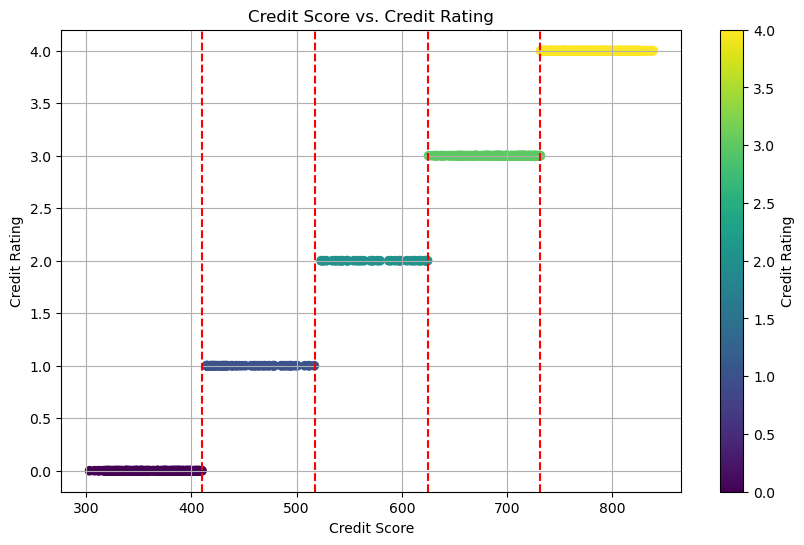

In [5]:
import matplotlib.pyplot as plt

# 可视化聚类结果
plt.figure(figsize=(10, 6))

# 绘制信用评分和信用等级的散点图

# 需要蔺经纬同志调配色！
plt.scatter(df['Credit_Score'], df['Credit_Rating'], c=credit_ratings, cmap='viridis', marker='o')
# 需要蔺经纬同志调配色！

plt.colorbar(label='Credit Rating')
plt.xlabel('Credit Score')
plt.ylabel('Credit Rating')
plt.title('Credit Score vs. Credit Rating')
plt.grid(True)

# 添加边界线
for boundary in optimal_boundaries[1:-1]:

    # 需要蔺经纬同志调配色！
    plt.axvline(scaler.inverse_transform([[boundary]])[0][0], color='r', linestyle='--')
    # 需要蔺经纬同志调配色！

plt.savefig('../Data/Q4_Credit_Score_vs_Credit_Rating.png')
plt.show()


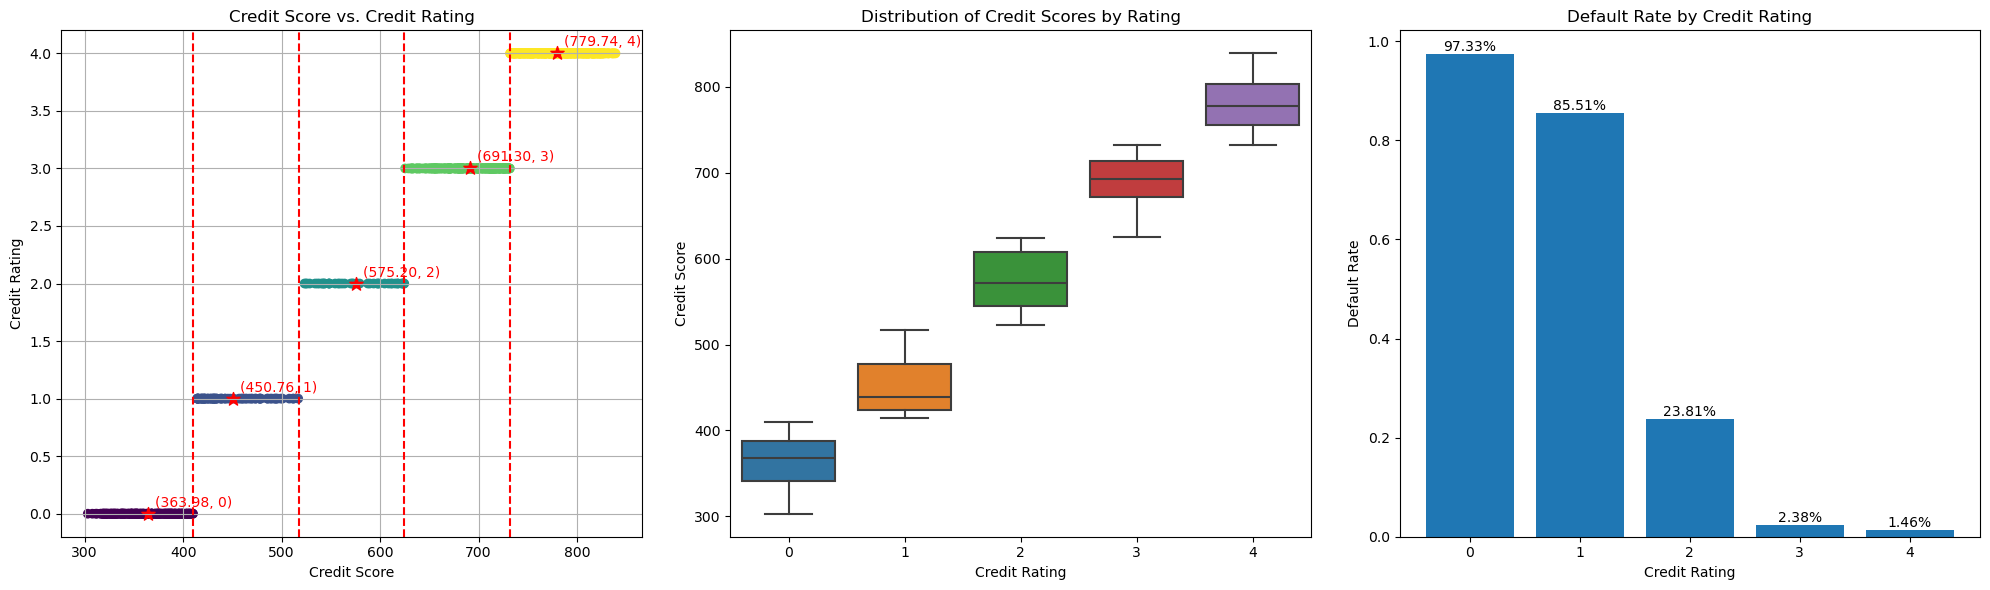

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算每个信用等级的平均信用评分（聚类中心）
cluster_centers = df.groupby('Credit_Rating')['Credit_Score'].mean()

# 创建一个包含三个子图的图形
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 第一个子图：信用评分vs信用等级的散点图
scatter = ax1.scatter(df['Credit_Score'], df['Credit_Rating'], c=credit_ratings, cmap='viridis', marker='o')
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Credit Rating')
ax1.set_title('Credit Score vs. Credit Rating')
ax1.grid(True)

# 添加聚类中心
for rating, center in cluster_centers.items():
    ax1.scatter(center, rating, color='red', s=100, marker='*')
    ax1.annotate(f'({center:.2f}, {rating})', (center, rating), xytext=(5, 5), 
                 textcoords='offset points', color='red')

# 添加边界线
for boundary in optimal_boundaries[1:-1]:
    ax1.axvline(scaler.inverse_transform([[boundary]])[0][0], color='r', linestyle='--')

# 第二个子图：信用评级的箱型图
sns.boxplot(x='Credit_Rating', y='Credit_Score', data=df, ax=ax2)
ax2.set_xlabel('Credit Rating')
ax2.set_ylabel('Credit Score')
ax2.set_title('Distribution of Credit Scores by Rating')

# 第三个子图：信用等级与违约率的关系条形图
default_rates = df.groupby('Credit_Rating')['Y(1=default, 0=non-default)'].mean()
ax3.bar(default_rates.index, default_rates.values)
ax3.set_xlabel('Credit Rating')
ax3.set_ylabel('Default Rate')
ax3.set_title('Default Rate by Credit Rating')
for i, v in enumerate(default_rates):
    ax3.text(i, v, f'{v:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../Data/Q4_Credit_Analysis.png')
plt.show()